In [ ]:
# doc : https://cometa.ujaen.es/datasets/genbase
# https://sci2s.ugr.es/keel/dataset/data/multilabel/genbase-names.txt

In [10]:

import warnings
import pandas as pd
warnings.filterwarnings("ignore")
# show graphs in jupyter
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# display all columns/rows and what's inside
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

In [11]:
# https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8#--responses
import matplotlib.pyplot as plt

import numpy as np
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import csv
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
from sklearn.svm import SVC
from skmultilearn.dataset import load_dataset
from skmultilearn.ext import Keras
from keras.models import Sequential
from keras.layers import Dense

In [12]:
# list of metrics
Evals = []

# 3. Multi-Label Classification


In [15]:
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("genbase.csv")


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data.protein = le.fit_transform(data.protein)

# Preview the first 5 lines of the loaded data 
print(data.shape)
# X_train, y_train
y = data.iloc[:,-27:]
X = data.iloc[:,:-27]
X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

(662, 1213)


In [16]:
data.head()

,protein,PS00010,PS00011,PS00012,PS00014,PS00017,PS00018,PS00019,PS00020,PS00021,PS00022,PS00023,PS00024,PS00025,PS00026,PS00027,PS00032,PS00033,PS00034,PS00035,PS00045,PS00046,PS00047,PS00048,PS00049,PS00050,PS00058,PS00059,PS00060,PS00061,PS00062,PS00063,PS00064,PS00065,PS00066,PS00067,PS00068,PS00069,PS00070,PS00071,PS00072,PS00073,PS00074,PS00084,PS00085,PS00086,PS00087,PS00088,PS00089,PS00090,PS00091,PS00092,PS00093,PS00094,PS00095,PS00096,PS00097,PS00098,PS00099,PS00100,PS00101,PS00102,PS00103,PS00111,PS00112,PS00113,PS00114,PS00115,PS00116,PS00117,PS00118,PS00119,PS00120,PS00121,PS00122,PS00123,PS00128,PS00129,PS00130,PS00131,PS00132,PS00133,PS00134,PS00135,PS00136,PS00137,PS00138,PS00139,PS00152,PS00154,PS00155,PS00156,PS00157,PS00158,PS00159,PS00160,PS00161,PS00162,PS00163,PS00164,PS00165,PS00166,PS00167,PS00168,PS00169,PS00177,PS00178,PS00179,PS00180,PS00181,PS00182,PS00183,PS00184,PS00185,PS00186,PS00187,PS00188,PS00189,PS00190,PS00191,PS00192,PS00193,PS00194,PS00195,PS00196,PS00197,PS00198,PS00199,PS00200,PS00201,PS00202,PS00203,PS00204,PS00205,PS00206,PS00207,PS00208,PS00209,PS00210,PS00211,PS00212,PS00213,PS00214,PS00215,PS00216,PS00217,PS00227,PS00228,PS00229,PS00230,PS00231,PS00232,PS00233,PS00234,PS00235,PS00236,PS00237,PS00238,PS00239,PS00240,PS00242,PS00243,PS00244,PS00245,PS00265,PS00266,PS00267,PS00268,PS00269,PS00270,PS00271,PS00272,PS00273,PS00274,PS00275,PS00276,PS00277,PS00278,PS00279,PS00280,PS00281,PS00282,PS00283,PS00284,PS00285,PS00286,PS00287,PS00288,PS00294,PS00296,PS00297,PS00298,PS00302,PS00303,PS00304,PS00306,PS00307,PS00308,PS00309,PS00310,PS00311,PS00312,PS00313,PS00317,PS00318,PS00319,PS00320,PS00321,PS00322,PS00324,PS00326,PS00327,PS00329,PS00330,PS00331,PS00332,PS00333,PS00335,PS00338,PS00339,PS00341,PS00343,PS00353,PS00354,PS00355,PS00357,PS00358,PS00359,PS00363,PS00364,PS00367,PS00368,PS00369,PS00370,PS00371,PS00372,PS00373,PS00374,PS00375,PS00379,PS00380,PS00381,PS00382,PS00385,PS00389,PS00390,PS00391,PS00392,PS00393,PS00394,...,PS50135,PS50136,PS50137,PS50138,PS50139,PS50140,PS50141,PS50142,PS50143,PS50144,PS50145,PS50146,PS50147,PS50148,PS50149,PS50150,PS50151,PS50152,PS50153,PS50154,PS50155,PS50156,PS50157,PS50158,PS50159,PS50160,PS50161,PS50162,PS50163,PS50164,PS50165,PS50166,PS50167,PS50168,PS50169,PS50170,PS50171,PS50172,PS50173,PS50174,PS50175,PS50176,PS50177,PS50178,PS50179,PS50180,PS50181,PS50182,PS50183,PS50184,PS50185,PS50186,PS50187,PS50188,PS50189,PS50190,PS50191,PS50192,PS50193,PS50194,PS50195,PS50196,PS50197,PS50198,PS50199,PS50200,PS50202,PS50203,PS50204,PS50205,PS50206,PS50207,PS50208,PS50209,PS50210,PS50211,PS50212,PS50213,PS50214,PS50215,PS50216,PS50217,PS50218,PS50219,PS50220,PS50221,PS50222,PS50223,PS50224,PS50225,PS50226,PS50227,PS50228,PS50229,PS50230,PS50231,PS50232,PS50233,PS50234,PS50235,PS50236,PS50237,PS50238,PS50239,PS50240,PS50241,PS50242,PS50243,PS50244,PS50245,PS50246,PS50247,PS50248,PS50249,PS50250,PS50251,PS50252,PS50253,PS50254,PS50255,PS50256,PS50257,PS50258,PS50259,PS50260,PS50261,PS50262,PS50263,PS50264,PS50265,PS50266,PS50267,PS50268,PS50269,PS50270,PS50271,PS50272,PS50273,PS50275,PS50276,PS50277,PS50278,PS50279,PS50280,PS50281,PS50282,PS50283,PS50284,PS50285,PS50286,PS50287,PS50288,PS50290,PS50291,PS50292,PS50293,PS50294,PS50295,PS50296,PS50297,PS50298,PS50299,PS50300,PS50301,PS50302,PS50303,PS50304,PS50305,PS50309,PS50310,PS50311,PS50312,PS50313,PS50314,PS50315,PS50316,PS50317,PS50318,PS50319,PS50320,PS50321,PS50322,PS50323,PS50324,PS50325,PS50326,PS50327,PS50328,PS50330,PS50404,PS50405,PS50600,PS50800,PS50801,PS50802,PS50803,PS50804,PS50805,PS50806,PS50807,PS50808,PS50809,PS50810,PS50811,PS50812,PS50813,PS50814,PS50815,PS50816,PS50817,PS50818,PS50819,PS50820,PS50821,PS50822,PS50823,PS50824,PS50825,PS50826,PS50827,PS50829,PS50830,PS60000,PDOC00154,PDOC00343,PDOC00271,PDOC00064,PDOC00791,PDOC00380,PDOC50007,PDOC00224,PDOC00100,PDOC00670,PDOC50002,PDOC50106,PDOC00561,PDOC50017,PDOC50003,PDOC50006,PDOC50156,PDOC00662,PDOC00018,PDOC50001,PDOC00014,P

## 3.1. Multiple Binary Classifications - (Binary Relevance)


### 3.1.1  BinaryRelevance MLP

In [17]:
def create_model_single_class(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

KERAS_PARAMS = dict(epochs=10, batch_size=100, verbose=0)
clf = BinaryRelevance(classifier=Keras(create_model_single_class, False, KERAS_PARAMS), require_dense=[True,True])
clf.fit(X_train, y_train)
result = clf.predict(X_test)

In [18]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,result.toarray())
Micro_Precision = precision_score(y_test,result, average='micro')
Micro_Recall = recall_score(y_test,result, average='micro')
Micro_F1 = f1_score(y_test,result, average='micro')
Micro_Average_Prec = average_precision_score(y_test, result.toarray(), average='micro')
Macro_Precision = precision_score(y_test,result, average='macro')
Macro_Recall = recall_score(y_test,result, average='macro')
Macro_F1 = f1_score(y_test,result, average='macro')
Macro_Average_Prec = average_precision_score(y_test, result.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, result.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, result.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,result)
Ranking_loss = label_ranking_loss(y_test, result.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test.toarray(), result)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), result.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, result.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, result.toarray())
Jaccard_score = jaccard_score(y_test, result.toarray(), average='samples')
Jaccard_score_macro = jaccard_score(y_test, result.toarray(), average='macro')
print("BinaryReMLP Accuracy = ",Accuracy)
print("BinaryReMLP Micro_Precision = ",Micro_Precision)
print("BinaryReMLP Micro_Recall = ",Micro_Recall)
print("BinaryReMLP Micro_F1 = ",Micro_F1)
print("BinaryReMLP Micro_Average_Prec = ",Micro_Average_Prec)
print("BinaryReMLP Macro_Precision = ",Macro_Precision)
print("BinaryReMLP Macro_Recall = ",Macro_Recall)
print("BinaryReMLP Macro_F1 = ",Macro_F1)
print("BinaryReMLP Macro_Average_Prec = ",Macro_Average_Prec)
print("BinaryReMLP Samples_Average_Prec = ",Samples_Average_Prec)
print("BinaryReMLP Weighted_Average_Prec = ",Weighted_Average_Prec)
print("BinaryReMLP Hamming_loss = ",Hamming_loss)
print("BinaryReMLP Ranking_loss = ",Ranking_loss)
print("BinaryReMLP Micro_Roc_auc = ",Micro_Roc_auc)
print("BinaryReMLP Coverage_error = ",Coverage_error)
print("BinaryReMLP label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("BinaryReMLP Jaccard_score = ",Jaccard_score)
print("BinaryReMLP Jaccard_score_macro = ",Jaccard_score_macro)
Eval1 = ['BinaryReMLP',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval1)

BinaryReMLP Accuracy =  0.0091324200913242
BinaryReMLP Micro_Precision =  1.0
BinaryReMLP Micro_Recall =  0.007434944237918215
BinaryReMLP Micro_F1 =  0.014760147601476014
BinaryReMLP Micro_Average_Prec =  0.05258968802279898
BinaryReMLP Macro_Precision =  0.037037037037037035
BinaryReMLP Macro_Recall =  0.0014814814814814814
BinaryReMLP Macro_F1 =  0.002849002849002849
BinaryReMLP Macro_Average_Prec =  nan
BinaryReMLP Samples_Average_Prec =  0.05428716387620497
BinaryReMLP Weighted_Average_Prec =  nan
BinaryReMLP Hamming_loss =  0.04515474378488077
BinaryReMLP Ranking_loss =  0.9908675799086758
BinaryReMLP Micro_Roc_auc =  0.5037174721189591
BinaryReMLP Coverage_error =  26.76255707762557
BinaryReMLP label_ranking_average_precision_score =  0.05428716387620475
BinaryReMLP Jaccard_score =  0.0091324200913242
BinaryReMLP Jaccard_score_macro =  0.0014814814814814814


### 3.1.2  BinaryRelevance SVM

In [19]:
# initialize Binary Relevance multi-label classifier
# with an SVM classifier  # SVM in scikit only supports the X matrix in sparse representation
# Setup the classifier
classifier = BinaryRelevance(classifier=SVC(), require_dense=[False,True])
# Train
classifier.fit(X_train, y_train)
# Predict
y_pred = classifier.predict(X_test)

In [20]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
# In multilabel classification, this function computes subset_accuracy:
Accuracy = accuracy_score(y_test,y_pred)  
Micro_Precision = precision_score(y_test,y_pred, average='micro')
Micro_Recall = recall_score(y_test,y_pred, average='micro')
Micro_F1 = f1_score(y_test,y_pred, average='micro')
Micro_Average_Prec = average_precision_score(y_test, y_pred.toarray(), average='micro')
Macro_Precision = precision_score(y_test,y_pred, average='macro')
Macro_Recall = recall_score(y_test,y_pred, average='macro')
Macro_F1 = f1_score(y_test,y_pred, average='macro')
Macro_Average_Prec = average_precision_score(y_test, y_pred.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, y_pred.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, y_pred.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,y_pred)
Ranking_loss = label_ranking_loss(y_test, y_pred.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, y_pred.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, y_pred.toarray())
Jaccard_score = jaccard_score(y_test, y_pred, average='samples')
Jaccard_score_macro = jaccard_score(y_test, y_pred, average='macro')
print("BinaryReSVC Accuracy = ",Accuracy)
print("BinaryReSVC Micro_Precision = ",Micro_Precision)
print("BinaryReSVC Micro_Recall = ",Micro_Recall)
print("BinaryReSVC Micro_F1 = ",Micro_F1)
print("BinaryReSVC Micro_Average_Prec = ",Micro_Average_Prec)
print("BinaryReSVC Macro_Precision = ",Macro_Precision)
print("BinaryReSVC Macro_Recall = ",Macro_Recall)
print("BinaryReSVC Macro_F1 = ",Macro_F1)
print("BinaryReSVC Macro_Average_Prec = ",Macro_Average_Prec)
print("BinaryReSVC Samples_Average_Prec = ",Samples_Average_Prec)
print("BinaryReSVC Weighted_Average_Prec = ",Weighted_Average_Prec)
print("BinaryReSVC Hamming_loss = ",Hamming_loss)
print("BinaryReSVC Ranking_loss = ",Ranking_loss)
print("BinaryReSVC Micro_Roc_auc = ",Micro_Roc_auc)
print("BinaryReSVC Coverage_error = ",Coverage_error)
print("BinaryReSVC label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("BinaryReSVC Jaccard_score = ",Jaccard_score)
print("BinaryReSVC Jaccard_score_macro = ",Jaccard_score_macro)
Eval2 = ['BinaryReSVC',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval2)

BinaryReSVC Accuracy =  0.0547945205479452
BinaryReSVC Micro_Precision =  0.75
BinaryReSVC Micro_Recall =  0.04460966542750929
BinaryReSVC Micro_F1 =  0.08421052631578946
BinaryReSVC Micro_Average_Prec =  0.07692080394971196
BinaryReSVC Macro_Precision =  0.02962962962962963
BinaryReSVC Macro_Recall =  0.008888888888888889
BinaryReSVC Macro_F1 =  0.013675213675213675
BinaryReSVC Macro_Average_Prec =  nan
BinaryReSVC Samples_Average_Prec =  0.09825807542702518
BinaryReSVC Weighted_Average_Prec =  nan
BinaryReSVC Hamming_loss =  0.0441400304414003
BinaryReSVC Ranking_loss =  0.9452054794520548
BinaryReSVC Micro_Roc_auc =  0.5219504741028403
BinaryReSVC Coverage_error =  25.575342465753426
BinaryReSVC label_ranking_average_precision_score =  0.09825807542702518
BinaryReSVC Jaccard_score =  0.0547945205479452
BinaryReSVC Jaccard_score_macro =  0.008385744234800839


### 3.1.3  BinaryRelevance GaussianNB

In [21]:
#Binary Relevance GaussianNB
BinaryReGaussianNB = BinaryRelevance(GaussianNB())
BinaryReGaussianNB.fit(X_train,y_train)
br_predictions = BinaryReGaussianNB.predict(X_test)

In [22]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,br_predictions.toarray())
Micro_Precision = precision_score(y_test,br_predictions, average='micro')
Micro_Recall = recall_score(y_test,br_predictions, average='micro')
Micro_F1 = f1_score(y_test,br_predictions, average='micro')
Micro_Average_Prec = average_precision_score(y_test, br_predictions.toarray(), average='micro')
Macro_Precision = precision_score(y_test,br_predictions, average='macro')
Macro_Recall = recall_score(y_test,br_predictions, average='macro')
Macro_F1 = f1_score(y_test,br_predictions, average='macro')
Macro_Average_Prec = average_precision_score(y_test, br_predictions.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, br_predictions.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, br_predictions.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,br_predictions)
Ranking_loss = label_ranking_loss(y_test, br_predictions.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test.toarray(), br_predictions)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), br_predictions.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, br_predictions.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, br_predictions.toarray())
Jaccard_score = jaccard_score(y_test, br_predictions, average='samples')
Jaccard_score_macro = jaccard_score(y_test, br_predictions, average='macro')
print("BinaryReGaussianNB Accuracy = ",Accuracy)
print("BinaryReGaussianNB Micro_Precision = ",Micro_Precision)
print("BinaryReGaussianNB Micro_Recall = ",Micro_Recall)
print("BinaryReGaussianNB Micro_F1 = ",Micro_F1)
print("BinaryReGaussianNB Micro_Average_Prec = ",Micro_Average_Prec)
print("BinaryReGaussianNB Macro_Precision = ",Macro_Precision)
print("BinaryReGaussianNB Macro_Recall = ",Macro_Recall)
print("BinaryReGaussianNB Macro_F1 = ",Macro_F1)
print("BinaryReGaussianNB Macro_Average_Prec = ",Macro_Average_Prec)
print("BinaryReGaussianNB Samples_Average_Prec = ",Samples_Average_Prec)
print("BinaryReGaussianNB Weighted_Average_Prec = ",Weighted_Average_Prec)
print("BinaryReGaussianNB Hamming_loss = ",Hamming_loss)
print("BinaryReGaussianNB Ranking_loss = ",Ranking_loss)
print("BinaryReGaussianNB Micro_Roc_auc = ",Micro_Roc_auc)
print("BinaryReGaussianNB Coverage_error = ",Coverage_error)
print("BinaryReGaussianNB label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("BinaryReGaussianNB Jaccard_score = ",Jaccard_score)
print("BinaryReGaussianNB Jaccard_score_macro = ",Jaccard_score_macro)
Eval3 = ['BinaryReGaussianNB',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval3)

BinaryReGaussianNB Accuracy =  0.954337899543379
BinaryReGaussianNB Micro_Precision =  0.9740740740740741
BinaryReGaussianNB Micro_Recall =  0.9776951672862454
BinaryReGaussianNB Micro_F1 =  0.9758812615955473
BinaryReGaussianNB Micro_Average_Prec =  0.9533622281445269
BinaryReGaussianNB Macro_Precision =  0.7191358024691357
BinaryReGaussianNB Macro_Recall =  0.7163749830416498
BinaryReGaussianNB Macro_F1 =  0.7117528158375984
BinaryReGaussianNB Macro_Average_Prec =  nan
BinaryReGaussianNB Samples_Average_Prec =  0.9743784880771182
BinaryReGaussianNB Weighted_Average_Prec =  nan
BinaryReGaussianNB Hamming_loss =  0.002198545577541011
BinaryReGaussianNB Ranking_loss =  0.011883854349607773
BinaryReGaussianNB Micro_Roc_auc =  0.988227456074023
BinaryReGaussianNB Coverage_error =  1.5936073059360731
BinaryReGaussianNB label_ranking_average_precision_score =  0.9743784880771182
BinaryReGaussianNB Jaccard_score =  0.9733637747336377
BinaryReGaussianNB Jaccard_score_macro =  0.69477004477004

## 3.2. Label Powerset


In [23]:
## initialize label powerset multi-label classifier
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(X_train, y_train)
lp_predictions = lp_classifier.predict(X_test)

In [24]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,lp_predictions.toarray())
Micro_Precision = precision_score(y_test,lp_predictions, average='micro')
Micro_Recall = recall_score(y_test,lp_predictions, average='micro')
Micro_F1 = f1_score(y_test,lp_predictions, average='micro')
Micro_Average_Prec = average_precision_score(y_test, lp_predictions.toarray(), average='micro')
Macro_Precision = precision_score(y_test,lp_predictions, average='macro')
Macro_Recall = recall_score(y_test,lp_predictions, average='macro')
Macro_F1 = f1_score(y_test,lp_predictions, average='macro')
Macro_Average_Prec = average_precision_score(y_test, lp_predictions.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, lp_predictions.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, lp_predictions.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,lp_predictions)
Ranking_loss = label_ranking_loss(y_test, lp_predictions.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test, lp_predictions)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), lp_predictions.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, lp_predictions.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, lp_predictions.toarray())
Jaccard_score = jaccard_score(y_test, lp_predictions, average='samples')
Jaccard_score_macro = jaccard_score(y_test, lp_predictions, average='macro')
print("LabelPowersetLogisticRegression Accuracy = ",Accuracy)
print("LabelPowersetLogisticRegression Micro_Precision = ",Micro_Precision)
print("LabelPowersetLogisticRegression Micro_Recall = ",Micro_Recall)
print("LabelPowersetLogisticRegression Micro_F1 = ",Micro_F1)
print("LabelPowersetLogisticRegression Micro_Average_Prec = ",Micro_Average_Prec)
print("LabelPowersetLogisticRegression Macro_Precision = ",Macro_Precision)
print("LabelPowersetLogisticRegression Macro_Recall = ",Macro_Recall)
print("LabelPowersetLogisticRegression Macro_F1 = ",Macro_F1)
print("LabelPowersetLogisticRegression Macro_Average_Prec = ",Macro_Average_Prec)
print("LabelPowersetLogisticRegression Samples_Average_Prec = ",Samples_Average_Prec)
print("LabelPowersetLogisticRegression Weighted_Average_Prec = ",Weighted_Average_Prec)
print("LabelPowersetLogisticRegression Hamming_loss = ",Hamming_loss)
print("LabelPowersetLogisticRegression Ranking_loss = ",Ranking_loss)
print("LabelPowersetLogisticRegression Micro_Roc_auc = ",Micro_Roc_auc)
print("LabelPowersetLogisticRegression Coverage_error = ",Coverage_error)
print("LabelPowersetLogisticRegression label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("LabelPowersetLogisticRegression Jaccard_score = ",Jaccard_score)
print("LabelPowersetLogisticRegression Jaccard_score_macro = ",Jaccard_score_macro)
Eval4 = ['LabelPowersetLogisticRegression',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval4)

LabelPowersetLogisticRegression Accuracy =  0.9726027397260274
LabelPowersetLogisticRegression Micro_Precision =  0.9961832061068703
LabelPowersetLogisticRegression Micro_Recall =  0.9702602230483272
LabelPowersetLogisticRegression Micro_F1 =  0.983050847457627
LabelPowersetLogisticRegression Micro_Average_Prec =  0.9679098908788902
LabelPowersetLogisticRegression Macro_Precision =  0.6289034132171387
LabelPowersetLogisticRegression Macro_Recall =  0.6031746031746031
LabelPowersetLogisticRegression Macro_F1 =  0.6126965023187978
LabelPowersetLogisticRegression Macro_Average_Prec =  nan
LabelPowersetLogisticRegression Samples_Average_Prec =  0.987197699983088
LabelPowersetLogisticRegression Weighted_Average_Prec =  nan
LabelPowersetLogisticRegression Hamming_loss =  0.0015220700152207
LabelPowersetLogisticRegression Ranking_loss =  0.014155251141552512
LabelPowersetLogisticRegression Micro_Roc_auc =  0.985041521871435
LabelPowersetLogisticRegression Coverage_error =  1.8858447488584476


# 3.3. Adapted Algorithm


In [25]:
#MLkNN
# Adapted Algorithm¶
# http://scikit.ml/api/api/skmultilearn.adapt.html#skmultilearn.adapt.MLkNN
ml_classifier = MLkNN(k=10)
# to prevent errors when handling sparse matrices.
X_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test).toarray()
ml_classifier.fit(X_train, y_train)
# predict
ml_predictions = ml_classifier.predict(X_test)

In [26]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,ml_predictions.toarray())
Micro_Precision = precision_score(y_test,ml_predictions, average='micro')
Micro_Recall = recall_score(y_test,ml_predictions, average='micro')
Micro_F1 = f1_score(y_test,ml_predictions, average='micro')
Micro_Average_Prec = average_precision_score(y_test, ml_predictions.toarray(), average='micro')
Macro_Precision = precision_score(y_test,ml_predictions, average='macro')
Macro_Recall = recall_score(y_test,ml_predictions, average='macro')
Macro_F1 = f1_score(y_test,ml_predictions, average='macro')
Macro_Average_Prec = average_precision_score(y_test, ml_predictions.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, ml_predictions.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, ml_predictions.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,ml_predictions)
Ranking_loss = label_ranking_loss(y_test, ml_predictions.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test, ml_predictions)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), ml_predictions.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, ml_predictions.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, ml_predictions.toarray())
Jaccard_score = jaccard_score(y_test, ml_predictions, average='samples')
Jaccard_score_macro = jaccard_score(y_test, ml_predictions, average='macro')
print("MLkNN Accuracy = ",Accuracy)
print("MLkNN Micro_Precision = ",Micro_Precision)
print("MLkNN Micro_Recall = ",Micro_Recall)
print("MLkNN Micro_F1 = ",Micro_F1)
print("MLkNN Micro_Average_Prec = ",Micro_Average_Prec)
print("MLkNN Macro_Precision = ",Macro_Precision)
print("MLkNN Macro_Recall = ",Macro_Recall)
print("MLkNN Macro_F1 = ",Macro_F1)
print("MLkNN Macro_Average_Prec = ",Macro_Average_Prec)
print("MLkNN Samples_Average_Prec = ",Samples_Average_Prec)
print("MLkNN Weighted_Average_Prec = ",Weighted_Average_Prec)
print("MLkNN Hamming_loss = ",Hamming_loss)
print("MLkNN Ranking_loss = ",Ranking_loss)
print("MLkNN Micro_Roc_auc = ",Micro_Roc_auc)
print("MLkNN Coverage_error = ",Coverage_error)
print("MLkNN label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("MLkNN Jaccard_score = ",Jaccard_score)
print("MLkNN Jaccard_score_macro = ",Jaccard_score_macro)
Eval5 = ['MLkNN',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval5)

MLkNN Accuracy =  0.1552511415525114
MLkNN Micro_Precision =  0.4375
MLkNN Micro_Recall =  0.13011152416356878
MLkNN Micro_F1 =  0.2005730659025788
MLkNN Micro_Average_Prec =  0.09649761221729955
MLkNN Macro_Precision =  0.13159371492704824
MLkNN Macro_Recall =  0.04180647884351588
MLkNN Macro_F1 =  0.05499531597578131
MLkNN Macro_Average_Prec =  nan
MLkNN Samples_Average_Prec =  0.19710806697108071
MLkNN Weighted_Average_Prec =  nan
MLkNN Hamming_loss =  0.0471841704718417
MLkNN Ranking_loss =  0.8424657534246576
MLkNN Micro_Roc_auc =  0.5610692277089993
MLkNN Coverage_error =  22.963470319634702
MLkNN label_ranking_average_precision_score =  0.19710806697108105
MLkNN Jaccard_score =  0.15753424657534246
MLkNN Jaccard_score_macro =  0.03192247025580359


## 3.4. Classifier Chains


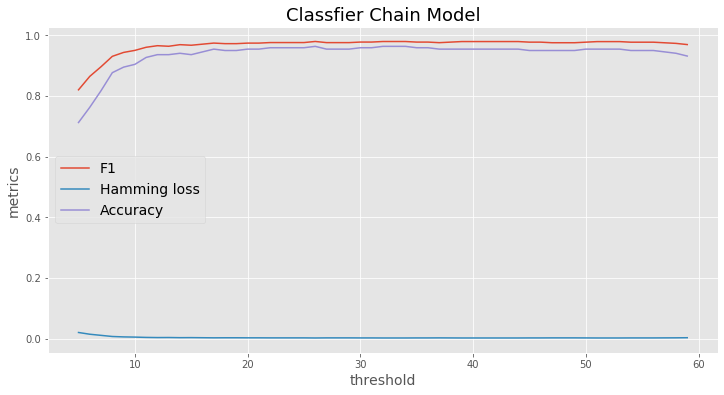

In [27]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
cc_classifier = ClassifierChain(LogisticRegression(solver='warn'))
cc_classifier.fit(X_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(X_test)
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
#     print("t =" ,t/100)
#     print("Accuracy = ",accuracy_score(y_test,y_pred_new))
#     print("F1 = ",f1_score(y_test,y_pred_new, average="micro"))
#     print("Hamming loss = ",hamming_loss(y_test,y_pred_new))
    th.append(t)
    ac.append(accuracy_score(y_test,y_pred_new))
    f.append(f1_score(y_test,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_test,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("Classfier Chain Model", fontsize = 18)
plt.show()

In [28]:
# using classifier chains
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)

In [29]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,predictions.toarray())
Micro_Precision = precision_score(y_test,predictions, average='micro')
Micro_Recall = recall_score(y_test,predictions, average='micro')
Micro_F1 = f1_score(y_test,predictions, average='micro')
Micro_Average_Prec = average_precision_score(y_test, predictions.toarray(), average='micro')
Macro_Precision = precision_score(y_test,predictions, average='macro')
Macro_Recall = recall_score(y_test,predictions, average='macro')
Macro_F1 = f1_score(y_test,predictions, average='macro')
Macro_Average_Prec = average_precision_score(y_test, predictions.toarray(), average='macro')
Samples_Average_Prec = average_precision_score(y_test, predictions.toarray(), average='samples')
Weighted_Average_Prec = average_precision_score(y_test, predictions.toarray(), average='weighted')
Hamming_loss = hamming_loss(y_test,predictions)
Ranking_loss = label_ranking_loss(y_test, predictions.toarray())
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#fpr["micro"], tpr["micro"], _  = roc_curve(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), predictions.toarray().ravel())
Micro_Roc_auc = auc(fpr, tpr)
Coverage_error = coverage_error(y_test, predictions.toarray())
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, predictions.toarray())
Jaccard_score = jaccard_score(y_test, predictions, average='samples')
Jaccard_score_macro = jaccard_score(y_test, predictions, average='macro')
print("ClassifierChain Accuracy = ",Accuracy)
print("ClassifierChain Micro_Precision = ",Micro_Precision)
print("ClassifierChain Micro_Recall = ",Micro_Recall)
print("ClassifierChain Micro_F1 = ",Micro_F1)
print("ClassifierChain Micro_Average_Prec = ",Micro_Average_Prec)
print("ClassifierChain Macro_Precision = ",Macro_Precision)
print("ClassifierChain Macro_Recall = ",Macro_Recall)
print("ClassifierChain Macro_F1 = ",Macro_F1)
print("ClassifierChain Macro_Average_Prec = ",Macro_Average_Prec)
print("ClassifierChain Samples_Average_Prec = ",Samples_Average_Prec)
print("ClassifierChain Weighted_Average_Prec = ",Weighted_Average_Prec)
print("ClassifierChain Hamming_loss = ",Hamming_loss)
print("ClassifierChain Ranking_loss = ",Ranking_loss)
print("ClassifierChain Micro_Roc_auc = ",Micro_Roc_auc)
print("ClassifierChain Coverage_error = ",Coverage_error)
print("ClassifierChain label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("ClassifierChain Jaccard_score = ",Jaccard_score)
print("ClassifierChain Jaccard_score_macro = ",Jaccard_score_macro)
Eval6 = ['ClassifierChain',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval6)

ClassifierChain Accuracy =  0.954337899543379
ClassifierChain Micro_Precision =  0.9961389961389961
ClassifierChain Micro_Recall =  0.9591078066914498
ClassifierChain Micro_F1 =  0.9772727272727273
ClassifierChain Micro_Average_Prec =  0.9572649955430761
ClassifierChain Macro_Precision =  0.5873015873015873
ClassifierChain Macro_Recall =  0.5556437389770723
ClassifierChain Macro_F1 =  0.5678586338811782
ClassifierChain Macro_Average_Prec =  nan
ClassifierChain Samples_Average_Prec =  0.973930323017081
ClassifierChain Weighted_Average_Prec =  nan
ClassifierChain Hamming_loss =  0.0020294266869609334
ClassifierChain Ranking_loss =  0.026879756468797564
ClassifierChain Micro_Roc_auc =  0.9794653136929963
ClassifierChain Coverage_error =  2.34703196347032
ClassifierChain label_ranking_average_precision_score =  0.973930323017081
ClassifierChain Jaccard_score =  0.9724505327245054
ClassifierChain Jaccard_score_macro =  0.5516754850088184


# 3.5. Multiple Binary Classifications - (One Vs Rest Classifier)


In [30]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])
# Training logistic regression model on train data
LogReg_pipeline.fit(X_train,y_train )
# calculating test accuracy
Logprediction = LogReg_pipeline.predict(X_test)

In [31]:
# accuracy   None, 'micro', 'macro', 'weighted', 'samples'
Accuracy = accuracy_score(y_test,Logprediction)
Micro_Precision = precision_score(y_test,Logprediction, average='micro')
Micro_Recall = recall_score(y_test,Logprediction, average='micro')
Micro_F1 = f1_score(y_test,Logprediction, average='micro')
Micro_Average_Prec = average_precision_score(y_test, Logprediction, average='micro')
Macro_Precision = precision_score(y_test,Logprediction, average='macro')
Macro_Recall = recall_score(y_test,Logprediction, average='macro')
Macro_F1 = f1_score(y_test,Logprediction, average='macro')
Macro_Average_Prec = average_precision_score(y_test, Logprediction, average='macro')
Samples_Average_Prec = average_precision_score(y_test, Logprediction, average='samples')
Weighted_Average_Prec = average_precision_score(y_test, Logprediction, average='weighted')
Hamming_loss = hamming_loss(y_test,Logprediction)
Ranking_loss = label_ranking_loss(y_test, Logprediction)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Logprediction.ravel())
Micro_Roc_auc = auc(fpr["micro"], tpr["micro"])
Coverage_error = coverage_error(y_test, Logprediction)
label_ranking_avg_prec_score = label_ranking_average_precision_score(y_test, Logprediction)
Jaccard_score = jaccard_score(y_test, Logprediction, average='samples')
Jaccard_score_macro = jaccard_score(y_test, Logprediction, average='macro')
print("OneVsRestClassifier_LogisticRegression Accuracy = ",Accuracy)
print("OneVsRestClassifier_LogisticRegression Micro_Precision = ",Micro_Precision)
print("OneVsRestClassifier_LogisticRegression Micro_Recall = ",Micro_Recall)
print("OneVsRestClassifier_LogisticRegression Micro_F1 = ",Micro_F1)
print("OneVsRestClassifier_LogisticRegression Micro_Average_Prec = ",Micro_Average_Prec)
print("OneVsRestClassifier_LogisticRegression Macro_Precision = ",Macro_Precision)
print("OneVsRestClassifier_LogisticRegression Macro_Recall = ",Macro_Recall)
print("OneVsRestClassifier_LogisticRegression Macro_F1 = ",Macro_F1)
print("OneVsRestClassifier_LogisticRegression Macro_Average_Prec = ",Macro_Average_Prec)
print("OneVsRestClassifier_LogisticRegression Samples_Average_Prec = ",Samples_Average_Prec)
print("OneVsRestClassifier_LogisticRegression Weighted_Average_Prec = ",Weighted_Average_Prec)
print("OneVsRestClassifier_LogisticRegression Hamming_loss = ",Hamming_loss)
print("OneVsRestClassifier_LogisticRegression Ranking_loss = ",Ranking_loss)
print("OneVsRestClassifier_LogisticRegression Micro_Roc_auc = ",Micro_Roc_auc)
print("OneVsRestClassifier_LogisticRegression Coverage_error = ",Coverage_error)
print("OneVsRestClassifier_LogisticRegression label_ranking_average_precision_score = ",label_ranking_avg_prec_score)
print("OneVsRestClassifier_LogisticRegression Jaccard_score = ",Jaccard_score)
print("OneVsRestClassifier_LogisticRegression Jaccard_score_macro = ",Jaccard_score_macro)
Eval7 = ['OneVsRestClassifier_LogisticRegression',Accuracy,Micro_Precision,Micro_Recall,Micro_F1,Micro_Average_Prec,
         Macro_Precision,Macro_Recall,Macro_F1,Macro_Average_Prec,Samples_Average_Prec,Weighted_Average_Prec,Hamming_loss,
         Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro]
Evals.append(Eval7)

OneVsRestClassifier_LogisticRegression Accuracy =  0.0091324200913242
OneVsRestClassifier_LogisticRegression Micro_Precision =  1.0
OneVsRestClassifier_LogisticRegression Micro_Recall =  0.007434944237918215
OneVsRestClassifier_LogisticRegression Micro_F1 =  0.014760147601476014
OneVsRestClassifier_LogisticRegression Micro_Average_Prec =  0.05258968802279898
OneVsRestClassifier_LogisticRegression Macro_Precision =  0.037037037037037035
OneVsRestClassifier_LogisticRegression Macro_Recall =  0.0014814814814814814
OneVsRestClassifier_LogisticRegression Macro_F1 =  0.002849002849002849
OneVsRestClassifier_LogisticRegression Macro_Average_Prec =  nan
OneVsRestClassifier_LogisticRegression Samples_Average_Prec =  0.05428716387620497
OneVsRestClassifier_LogisticRegression Weighted_Average_Prec =  nan
OneVsRestClassifier_LogisticRegression Hamming_loss =  0.04515474378488077
OneVsRestClassifier_LogisticRegression Ranking_loss =  0.9908675799086758
OneVsRestClassifier_LogisticRegression Micro_R

In [32]:
df = pd.DataFrame(Evals, columns=['Classifier','Accuracy','Micro_Pre','Micro_Recall','Micro_F1','Micro_Avg_Prec',
         'Macro_Prec','Macro_Recall','Macro_F1','Macro_Avg_Prec','Samples_Avg_Prec','Weighted_Avg_Prec','Hamming_loss',
         'Ranking_loss','Micro_Roc_auc','Coverage_error','label_ranking_avg_prec_score','Jaccard_score','Jaccard_score_macro'])
df

,Classifier,Accuracy,Micro_Pre,Micro_Recall,Micro_F1,Micro_Avg_Prec,Macro_Prec,Macro_Recall,Macro_F1,Macro_Avg_Prec,Samples_Avg_Prec,Weighted_Avg_Prec,Hamming_loss,Ranking_loss,Micro_Roc_auc,Coverage_error,label_ranking_avg_prec_score,Jaccard_score,Jaccard_score_macro
0,BinaryReMLP,0.009132,1.000000,0.007435,0.014760,0.052590,0.037037,0.001481,0.002849,NaN,0.054287,NaN,0.045155,0.990868,0.503717,26.762557,0.054287,0.009132,0.001481
1,BinaryReSVC,0.054795,0.750000,0.044610,0.084211,0.076921,0.029630,0.008889,0.013675,NaN,0.098258,NaN,0.044140,0.945205,0.521950,25.575342,0.098258,0.054795,0.008386
2,BinaryReGaussianNB,0.954338,0.974074,0.977695,0.975881,0.953362,0.719136,0.716375,0.711753,NaN,0.974378,NaN,0.002199,0.011884,0.988227,1.593607,0.974378,0.973364,0.694770
3,LabelPowersetLogisticRegression,0.972603,0.996183,0.970260,0.983051,0.967910,0.628903,0.603175,0.612697,NaN,0.987198,NaN,0.001522,0.014155,0.985042,1.885845,0.987198,0.985845,0.602448
4,MLkNN,0.155251,0.437500,0.130112,0.200573,0.096498,0.131594,0.041806,0.054995,NaN,0.197108,NaN,0.047184,0.842466,0.561069,22.963470,0.197108,0.157534,0.031922
5,ClassifierChain,0.954338,0.996139,0.959108,0.977273,0.957265,0.587302,0.555644,0.567859,NaN,0.973930,NaN,0.002029,0.026880,0.979465,2.347032,0.973930,0.972451,0.551675
6,OneVsRestClassifier_LogisticRegression,0.009132,1.000000,0.007435,0.014760,0.052590,0.037037,0.001481,0.002849,NaN,0.054287,NaN,0.045155,0.990868,0.503717,26.762557,0.054287,0.009132,0.001481


In [33]:
# Print the confusion matrix
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
#print(multilabel_confusion_matrix(y_test, Logprediction))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, Logprediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        12
           4       1.00      0.04      0.08        50
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        30
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         5
          17       0.00    

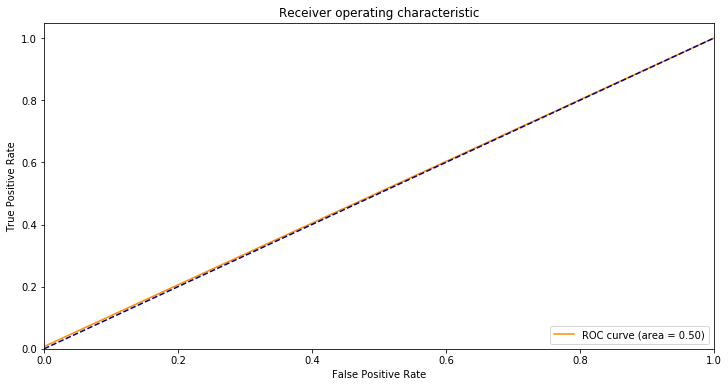

In [34]:
#https://www.programcreek.com/python/example/81207/sklearn.metrics.roc_curve
def print_roc(y_true, y_scores):
        '''
        Prints the ROC for this model.
        '''
        fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_scores.ravel())
        auc_score = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% auc_score)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show() 
print_roc(y_test, Logprediction)

In [ ]:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [ ]:
https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()